## Importation des données

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

## Chargement des données

In [2]:
X_train = np.load("../data/X_train_img.npy")   # (N, 28, 28)
X_val   = np.load("../data/X_val_img.npy")
y_train = np.load("../data/y_train.npy")
y_val   = np.load("../data/y_val.npy")

# Convertir en tenseurs PyTorch
X_train_t = torch.tensor(X_train).unsqueeze(1).float()  # (N,1,28,28)
X_val_t   = torch.tensor(X_val).unsqueeze(1).float()
y_train_t = torch.tensor(y_train).long()
y_val_t   = torch.tensor(y_val).long()

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=256)

## Création du modèle CNN

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.MaxPool2d(2), nn.Dropout(0.5),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2), nn.Dropout(0.5)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 256), nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.6),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)

## Entrainement

In [4]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

# Scheduler : divise le lr par 2 tous les 10 epochs
scheduler = StepLR(opt, step_size=5, gamma=0.7)

train_losses, val_losses, val_accs = [], [], []

for epoch in range(50):  # suffisant pour dépasser 99% acc
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    train_losses.append(total_loss/len(train_dl))

    # Validation
    model.eval()
    val_loss, correct, total = 0,0,0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item()
            correct += (pred.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_losses.append(val_loss/len(val_dl))
    val_accs.append(correct/total)

    # Scheduler step à la fin de l’epoch
    scheduler.step()

    # Affichage
    print(f"Epoch {epoch+1}: "
          f"TrainLoss={train_losses[-1]:.4f}, "
          f"ValLoss={val_losses[-1]:.4f}, "
          f"ValAcc={val_accs[-1]*100:.2f}%, "
          f"LR={scheduler.get_last_lr()[0]:.6f}")


Epoch 1: TrainLoss=0.2455, ValLoss=0.0587, ValAcc=98.05%, LR=0.001000
Epoch 2: TrainLoss=0.0870, ValLoss=0.0409, ValAcc=98.88%, LR=0.001000
Epoch 3: TrainLoss=0.0700, ValLoss=0.0361, ValAcc=98.83%, LR=0.001000
Epoch 4: TrainLoss=0.0570, ValLoss=0.0324, ValAcc=98.93%, LR=0.001000
Epoch 5: TrainLoss=0.0511, ValLoss=0.0291, ValAcc=99.24%, LR=0.000700
Epoch 6: TrainLoss=0.0423, ValLoss=0.0234, ValAcc=99.40%, LR=0.000700
Epoch 7: TrainLoss=0.0394, ValLoss=0.0230, ValAcc=99.26%, LR=0.000700
Epoch 8: TrainLoss=0.0370, ValLoss=0.0239, ValAcc=99.43%, LR=0.000700
Epoch 9: TrainLoss=0.0355, ValLoss=0.0247, ValAcc=99.40%, LR=0.000700
Epoch 10: TrainLoss=0.0348, ValLoss=0.0232, ValAcc=99.38%, LR=0.000490
Epoch 11: TrainLoss=0.0289, ValLoss=0.0242, ValAcc=99.24%, LR=0.000490
Epoch 12: TrainLoss=0.0274, ValLoss=0.0214, ValAcc=99.38%, LR=0.000490
Epoch 13: TrainLoss=0.0253, ValLoss=0.0203, ValAcc=99.40%, LR=0.000490
Epoch 14: TrainLoss=0.0244, ValLoss=0.0200, ValAcc=99.50%, LR=0.000490
Epoch 15: Train

## Visualisation

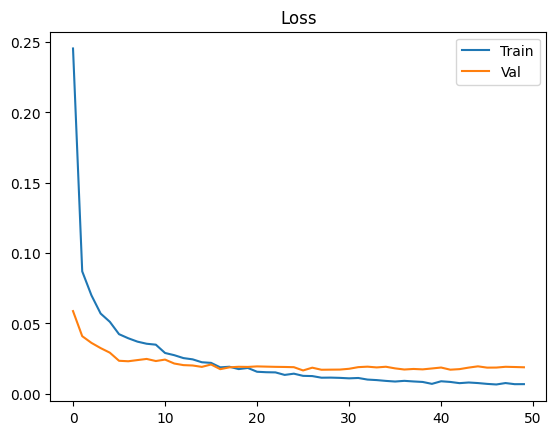

In [5]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Loss")
plt.legend()
plt.show()

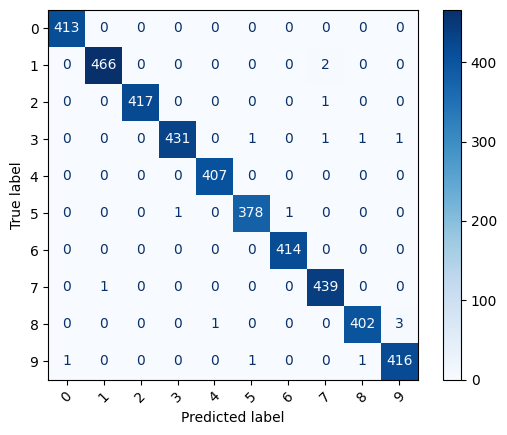

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Sur le jeu de validation
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb).argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()


Nombre d'images mal classées : 17


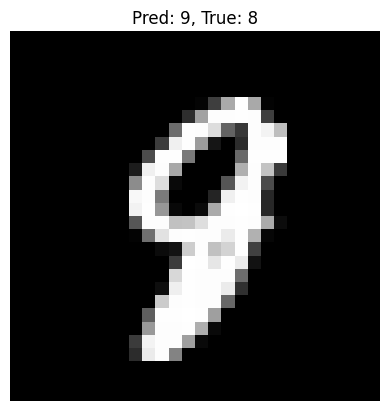

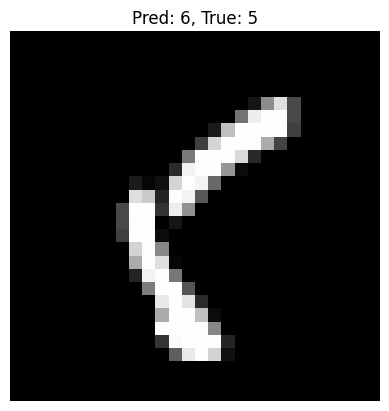

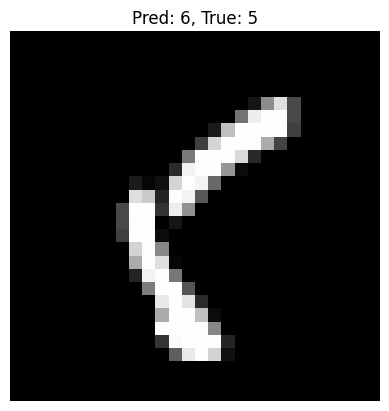

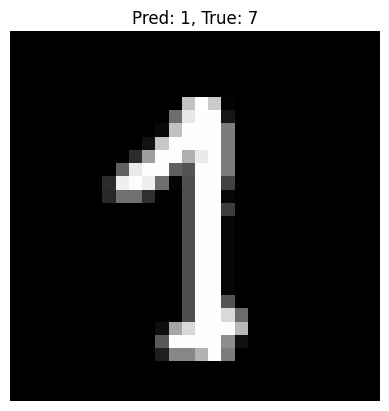

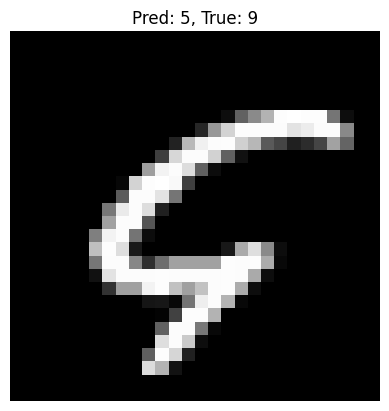

In [7]:
import random

# Récupération des prédictions sur le set de validation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb).argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Conversion en numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Trouver les indices des mauvaises prédictions
wrong_idx = np.where(all_preds != all_labels)[0]

print(f"Nombre d'images mal classées : {len(wrong_idx)}")

# Afficher 5 erreurs aléatoires
for i in range(5):
    idx = random.choice(wrong_idx)
    img = X_val[idx]  # shape (28,28)
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {all_preds[idx]}, True: {all_labels[idx]}")
    plt.axis("off")
    plt.show()



## Inférence pour Kaggle

In [8]:
# Chargement du test
X_test = np.load("../data/test_img.npy")  # (N, 28, 28)

# Conversion en tenseur PyTorch
X_test_t = torch.tensor(X_test).unsqueeze(1).float()  # (N,1,28,28)
test_dl = DataLoader(X_test_t, batch_size=256)

# Prédictions
model.eval()
preds = []
with torch.no_grad():
    for xb in test_dl:
        xb = xb.to(device)
        out = model(xb)
        preds.extend(out.argmax(1).cpu().numpy())

import pandas as pd

submission = pd.DataFrame({
    "ImageId": np.arange(1, len(preds)+1),
    "Label": preds
})

submission.to_csv("../results/submission_cnn_model.csv", index=False)
print("✅ Fichier submission.csv généré !")


✅ Fichier submission.csv généré !
